<a href="https://colab.research.google.com/github/Megancodes2017/Megancodes2017/blob/main/Harper_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 13.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
from pybaseball import batting_stats, statcast_batter
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
# Load in data for all hitters from 2015-2025
years = list(range(2015, 2025))
all_stats = pd.concat([batting_stats(year) for year in years], ignore_index=True)
all_stats = all_stats[all_stats['PA'] >= 100]   #Filter out low sample sizes

In [4]:
# Create future target (next years wOBA)
all_stats['next_year'] = all_stats['Season'] + 1
future = all_stats[['Name', 'Season', 'wOBA']].rename(columns={'wOBA': 'next_year_wOBA', 'Season': 'next_year'})
merged = all_stats.merge(future, on=['Name', 'next_year'])

In [5]:
# Feature selection and engineering
features = ['Season', 'Age', 'PA', 'BB%', 'K%', 'AVG', 'OBP', 'SLG', 'ISO', 'BABIP', 'wRC+', 'WAR']
merged = merged.dropna(subset=features + ['next_year_wOBA'])

X = merged[features]
y = merged['next_year_wOBA']

In [6]:
# Train/test split and model fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LGBMRegressor()
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1262
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 12
[LightGBM] [Info] Start training from score 0.342528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [7]:
# Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0010


In [8]:
# Predict for Bryce Harper
bryce = all_stats[all_stats['Name'] == 'Bryce Harper'].sort_values(by='Season', ascending=False).head(1)

if not bryce.empty:
  bryce_input = bryce[features]
  bryce_woba_pred = model.predict(bryce_input)
  print(f"Predicted next year wOBA for Bryce Harper: {bryce_woba_pred[0]:.3f}")
else:
  print('Bryce Harper data not found')

Predicted next year wOBA for Bryce Harper: 0.378


In [9]:
# create multi-year future targets
for i in range(1, 4):
  all_stats[f'future_year_{i}'] = all_stats['Season'] + i

future_targets = []
for i in range(1, 4):
  future = all_stats[['Name', 'Season', 'wOBA']].rename(
      columns = {'wOBA': f'wOBA_plus_{i}', 'Season': f'future_year_{i}'})
  future_targets.append(future)

merged = all_stats.copy()
for i in range(1, 4):
  merged = merged.merge(future_targets[i-1], on=['Name', f'future_year_{i}'], how='inner')


In [10]:
# Feature selection and engineering
features = ['Season', 'Age', 'PA', 'BB%', 'K%', 'AVG', 'OBP', 'SLG', 'ISO', 'BABIP', 'wRC+', 'WAR']
targets = ['wOBA_plus_1', 'wOBA_plus_2', 'wOBA_plus_3']
merged = merged.dropna(subset=features + targets)

X = merged[features]

In [11]:
# Train one model per future year
models = {}
predictions = {}

for i, target in enumerate(targets, start=1):
  y = merged[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = LGBMRegressor()
  model.fit(X_train, y_train)
  models[i] = model
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  print(f'Year +{i} Test MSE: {mse:.4f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 12
[LightGBM] [Info] Start training from score 0.351591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [12]:
# Predict for Bryce Harper next 3 years
bryce = all_stats[all_stats['Name'] == 'Bryce Harper'].sort_values(by='Season', ascending=False).head(1)

if not bryce.empty:
  bryce_input = bryce[features]
  for i in range(1, 4):
    bryce_pred = models[i].predict(bryce_input)
    print(f"Predicted wOBA for Bryce Harper in Year +{i}: {bryce_pred[0]:.3f}")
else:
  print('Bryce Harper data not found.')


Predicted wOBA for Bryce Harper in Year +1: 0.345
Predicted wOBA for Bryce Harper in Year +2: 0.369
Predicted wOBA for Bryce Harper in Year +3: 0.328


In [13]:
import matplotlib.pyplot as plt

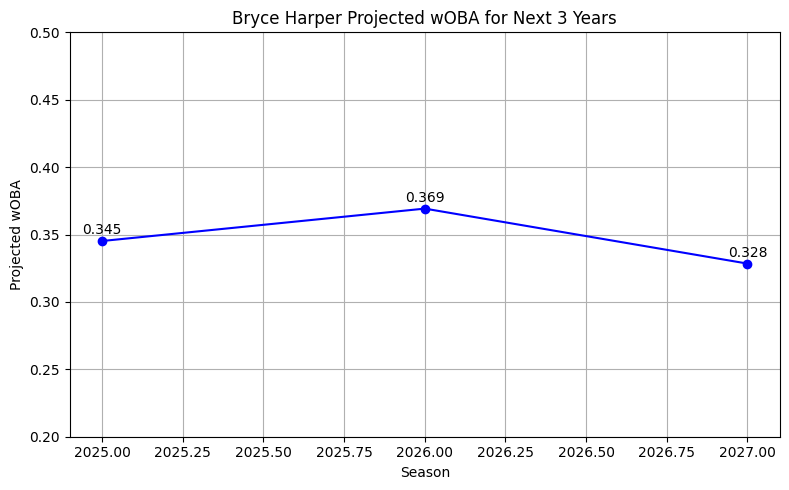

In [15]:
# Visualization
future_years = [bryce['Season'].values[0] + i for i in range(1, 4)]
bryce_predictions = []
for i in range(1, 4):
  bryce_predictions.append(models[i].predict(bryce_input)[0])

plt.figure(figsize=(8,5))
plt.plot(future_years, bryce_predictions, marker='o', linestyle='-', color='blue')
for year, woba in zip(future_years, bryce_predictions):
  plt.text(year, woba + 0.005, f"{woba:.3f}", ha='center', fontsize=10, color='black')
plt.title('Bryce Harper Projected wOBA for Next 3 Years')
plt.xlabel('Season')
plt.ylabel('Projected wOBA')
plt.ylim(0.200, 0.500)
plt.grid(True)
plt.tight_layout()
plt.show()